# TEAM 3 DYNAMICS II 

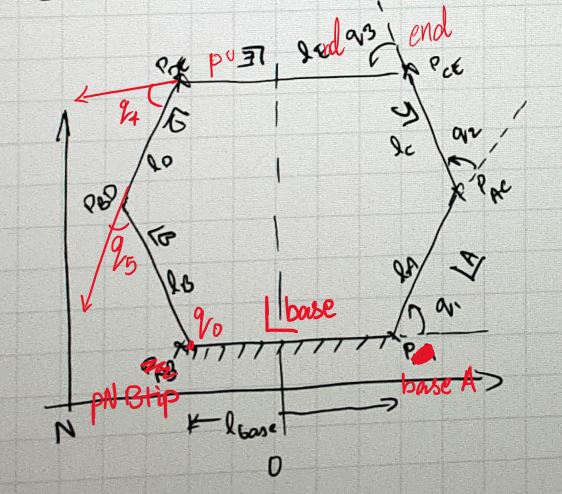

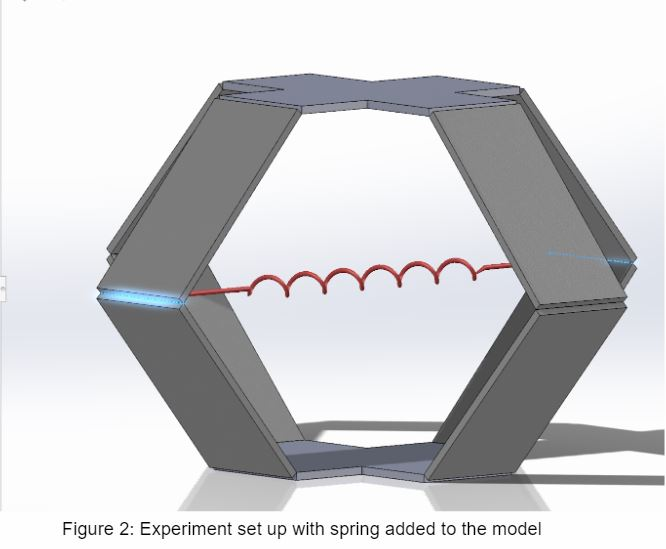

The Dynamics model shown in the figure above represents the sarrus mechanism used for our system to achieve motion of calf muscle during the human running gate cycle. The exterioir axis represents the Newtonian frame and the 6 links represent the frames of references. All of the link vectors are relative to the Newtonian frame shown in the figure.

In [1]:
%matplotlib inline

In [2]:
pip install pynamics

     |████████████████████████████████| 87 kB 2.4 MB/s 


In [3]:
#import packages
use_constraints = True

import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import KinematicConstraint,AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import scipy.optimize
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [4]:
system = System()
pynamics.set_system(__name__,system)

## Procedure and Discussion

#### 1. Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.

Declaring all the constants using SI units.
The length of each link can be obtained using the kinematics model. The units of dynamics were scaled to avoid any numerical error or the solver to diverge. The top and bottom links have twice the parameters as compared to the other four links on the side. The masses are estimated values of the links.

Changing our link lengths in the dynamics model based on the prototype and parameter ID plan. Our plan is to use 120mm long links for all the 4 side links and 150mm for the base and top links. Link lengths are in meter(m) for the simulation. These are same link lengths that were used in the solidworks simulation to calculate the damping factor.

Chaning our link masses based on the material to be used in manufacturing (Cardstock). One 4 X 2 inch cardstock link weighs 3gms and since we will have two layers of card stock we are considering link mass to be 6gms. The link masses were calculated using a kitchen weight scale. The top link approximately weighs at 0.015 kg since we will be placing the motor on the top link. For the pupose of the simulation we are neglecting the mass of the joint material (plastic) as it is very light weight and will not affect other parameters. Link masses are in (kg) for the simulation.

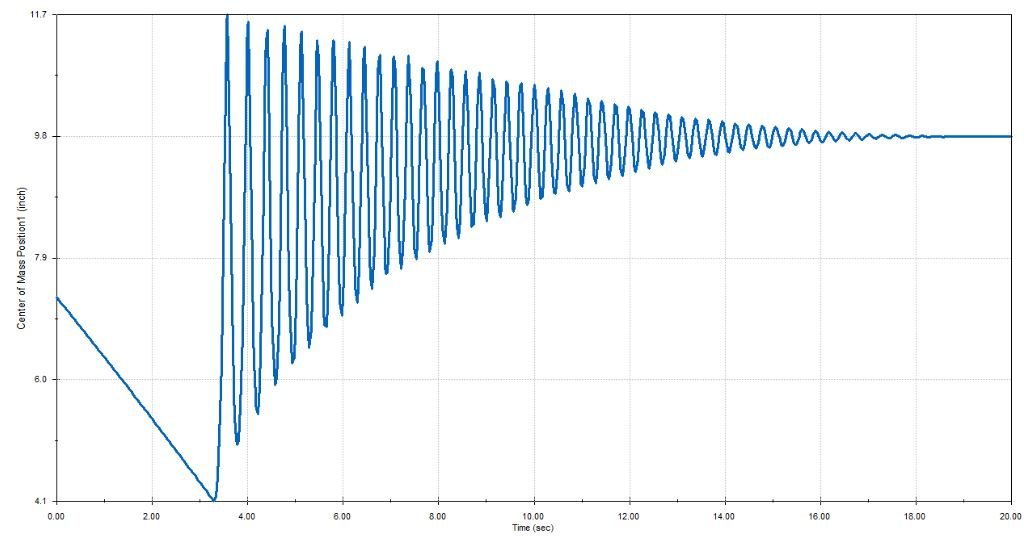

The experiment's goal is to find the damping factor of the system using Solidworks motion analysis. Based on our design, the actuator will rotate the links to compress the robot structure and extend the rubber band for storing energy. After the robot is fully compressed, the actuator will be disabled. The rubber band will release energy quickly, resulting in the robot taking off from the ground to simulate human muscle.
Free vibration trace measurements show a 13% reduction in vibration amplitude after 27 cycles. At the time 3.59 seconds, the displacement was 11.7 inches, and it decreased to 10.2 at 11.67 seconds. The decline link from 0 to 3.27 seconds was when the actuator compressed the robot. Based on the calculation, the damping coefficient is 0.0041.

For our actuator we will be using a Feetech 360 degree rotation servo motor. The specification of the motor are as follows. 

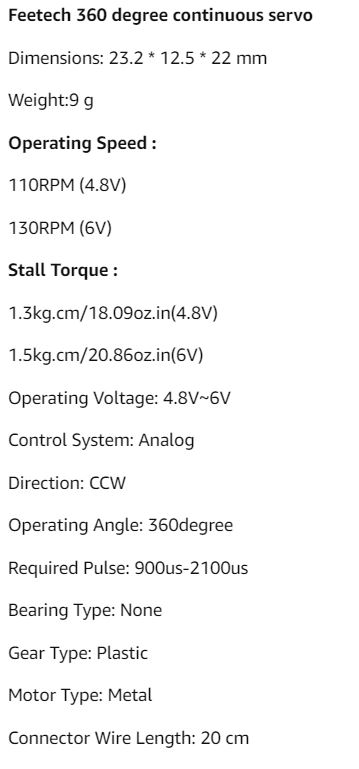

In [5]:
#Link lengths
lbase = Constant(0.15,'lbase',system)
lA = Constant(0.12,'lA',system)
lC = Constant(0.12,'lC',system)
lend = Constant(0.15,'lend',system)
lD = Constant(0.12,'lD',system)
lB = Constant(0.12,'lB',system)

#Link Masses
mbase = Constant(0.006,'mbase',system)
mA = Constant(0.006,'mA',system)
mC = Constant(0.006,'mC',system)
mend = Constant(0.015,'mend',system)
mD = Constant(0.006,'mD',system)
mB = Constant(0.006,'mB',system)

g = Constant(9.81,'g',system)
b = Constant(0.0041,'b',system)
k = Constant(0.01,'k',system)

#Adding spring preloads for all the links to establish neutral point
preload0 = Constant(0*pi/180,'preload0',system)
preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(90*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)
preload4 = Constant(0*pi/180,'preload4',system)
preload5 = Constant(90*pi/180,'preload5',system)

#Defining inertia of each frame
Ixx_base = Constant(1,'Ixx_base',system)
Iyy_base = Constant(1,'Iyy_base',system)
Izz_base = Constant(1,'Izz_base',system)
Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)
Ixx_D = Constant(1,'Ixx_D',system)
Iyy_D = Constant(1,'Iyy_D',system)
Izz_D = Constant(1,'Izz_D',system)
Ixx_end = Constant(1,'Ixx_end',system)
Iyy_end = Constant(1,'Iyy_end',system)
Izz_end = Constant(1,'Izz_end',system)


torque = Constant(0.220,'torque',system)
freq = Constant(0,'freq',system)

In [6]:
# Create the differentiable state variables, corresponding to the joint angles
q0,q0_d,q0_dd = Differentiable('q0',system)
q1,q1_d,q1_dd = Differentiable('q1',system)
q2,q2_d,q2_dd = Differentiable('q2',system)
q3,q3_d,q3_dd = Differentiable('q3',system)
q4,q4_d,q4_dd = Differentiable('q4',system)
q5,q5_d,q5_dd = Differentiable('q5',system)

The time frame is set to end once the system has maintained a Steady State. Time step is set to be 1 step per frame at 30 frames a second (1/30). Integration Tolerance is set to 1e-4 to keep some integration accuracy, while allowing a quicker integration time.

In [7]:
# Specifying how precise the integration should perform
# Defining the variables for time to be used in the script
tol = 1e-5
tinitial = 0
tfinal = 5
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [8]:
# Initial guesses for the meachanism starting point
initialvalues = {}
initialvalues[q0] = 0*pi/180
initialvalues[q0_d] = 0*pi/180
initialvalues[q1]=45*pi/180          
initialvalues[q1_d]=0*pi/180
initialvalues[q2]=90*pi/180         
initialvalues[q2_d]=0*pi/180
initialvalues[q3]=45*pi/180           
initialvalues[q3_d]=0*pi/180
initialvalues[q4]=45*pi/180
initialvalues[q4_d]=0*pi/180
initialvalues[q5]=90*pi/180
initialvalues[q5_d]=0*pi/180

In [9]:
# This helps to order the initial values in a list in a way so that the integrator can use it in the same order that it excepts to be supplied.   
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [10]:
N = Frame('N',system)
base = Frame('base',system)
A = Frame('A',system)
C = Frame('C',system)
end = Frame('end',system)
D = Frame('D',system)
B = Frame('B',system)

In [11]:
system.set_newtonian(N)


In [12]:
base.rotate_fixed_axis(N,[0,0,1],q0,system)
A.rotate_fixed_axis(base,[0,0,1],q1,system)
C.rotate_fixed_axis(A,[0,0,1],q2,system)
end.rotate_fixed_axis(C,[0,0,1],q3,system)
D.rotate_fixed_axis(end,[0,0,1],q4,system)
B.rotate_fixed_axis(D,[0,0,1],q5,system)

In [13]:
pNbase= 0*N.x + 0*N.y + 0*N.z
pbaseA = pNbase + lbase*base.x
pAC= pbaseA + lA*A.x
pCend= pAC + lC*C.x
pendD= pCend + lend*end.x
pDB = pendD + lD*D.x
pNBtip = pDB + lB*B.x

In [14]:
points = [pNbase,pbaseA,pAC,pCend,pendD,pDB,pNBtip]
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [15]:
pbasecm= pNbase + lbase/2*base.x
pAcm = pbaseA +lA/2*A.x
pCcm= pAC + lC/2*C.x 
pendcm= pCend + lend/2*end.x
pDcm= pendD + lD/2*D.x
pBcm= pDB + lB/2*B.x

In [16]:
wNbase = N.get_w_to(base)
wbaseA = base.get_w_to(A)
wbaseB = base.get_w_to(B)
wAC = A.get_w_to(C)
wCend = C.get_w_to(end)
wendD = end.get_w_to(D)
wDB = D.get_w_to(B)

In [17]:
vNBtip = pNBtip.time_derivative(N,system)

#### 2. Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame. You may use particles for now if you are not sure of the inertial properties of your bodies, but you should plan on finding these values soon for any “payloads” or parts of your system that carry extra loads (other than the weight of paper).

Defining Inertias. We are adding center of mass and a particle to each rotational frame since we are not sure of the inertial properties of our bodies. 
The center of masses is located in the center of each link based on our current paper prototype.
We are using inertia values as 1 for all the links to help us aid with the calculations. More accurate values for the bodies will be provided in future assignments.   



In [18]:
Ibase = Dyadic.build(N,Ixx_base,Iyy_base,Izz_base)
IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)
Iend = Dyadic.build(end,Ixx_end,Iyy_end,Izz_end)

Bodybase = Body('Bodybase',base,pbasecm,mbase,Ibase,system)
BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
Bodyend = Body('Bodyend',end,pendcm,mend,Iend,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)

In [19]:
system.addforce(-torque*sympy.sin(freq*2*sympy.pi*system.t)*C.z,wCend)

In [20]:
system.add_spring_force1(0,(q0-preload0)*N.z,wNbase)
system.add_spring_force1(0,(q1-preload1)*base.z,wbaseA)
system.add_spring_force1(k,(q2-preload2)*A.z,wAC)
system.add_spring_force1(k,(q3-preload3)*C.z,wCend)
system.add_spring_force1(k,(q4-preload4)*end.z,wendD)
system.add_spring_force1(k,(q5-preload5)*D.z,wDB)

(<pynamics.force.Force at 0x7f40e0d980d0>,
 <pynamics.spring.Spring at 0x7f40e0d97810>)

#### 3.Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint. You do not need to add external motor/spring forces but you should start planning to collect that data.

In [21]:
system.addforce(0*wNbase,wNbase)
system.addforce(0*wbaseA,wbaseA)
system.addforce(-b*wbaseB,wbaseB)
system.addforce(-b*wAC,wAC)
system.addforce(-b*wCend,wCend)
system.addforce(-b*wendD,wendD)
system.addforce(-b*wDB,wDB)

In [22]:
system.addforcegravity(-g*N.y)

#### 4.Constraints: Keep mechanism constraints in, but follow the pendulum example of double-differentiating all constraint equations.

If you defined your mechanism as unattached to the Newtonian frame, add enough constraints so that it is fully attached to ground (for now). you will be eventually removing these constraints.
Constraints are defined to prevent motion of certain elements in the mechanism. The last link in the sarrus mechanism is connected pNBtip to the fixed ground and base. 
The center joint on the left side pDB is constrained to stay along the same height as the center joint on right side pAC
The base link is aslo grounded to the ground so that there is motion only by the top (end) link.


In [23]:
eq1 = [pNBtip - pNbase]
eq2 = [pDB - pAC]
eq3 = [pNbase - pbaseA]

In [24]:
# Converting vector constraints into scalar quantities to make it solvable (Referring back to Solving Nonlinear Four-Bar Constraints Example )

eq = []

# pNBtip and base frame should be in the same x and y axis of N frame
eq.append((eq1[0]).dot(N.x))
eq.append((eq1[0]).dot(N.y))

# pCend and pendD should be in the same y axis from Newtonian frame
eq.append((eq2[0]).dot(end.y)) 

# pNbase and pbaseA are the same distance in y axis from the newtonian frame
eq.append((eq3[0]).dot(N.y))

    
#Adding Derivative constraints and substituing in the system constants    
eq_d = []
eq_d = [system.derivative(item) for item in eq]
    
eq_dd = []
eq_dd = [system.derivative(item) for item in eq_d]

    
system.add_constraint(AccelerationConstraint(eq_dd))

  
print(eq)

[-lA*sin(q0)*sin(q1) + lA*cos(q0)*cos(q1) + lB*(-(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*sin(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*cos(q2))*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*sin(q3) + (sin(q4)*cos(q5) + sin(q5)*cos(q4))*cos(q3)) + lB*((-sin(q0)*sin(q1) + cos(q0)*cos(q1))*cos(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*sin(q2))*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*cos(q3) - (sin(q4)*cos(q5) + sin(q5)*cos(q4))*sin(q3)) + lC*(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*cos(q2) + lC*(-sin(q0)*cos(q1) - sin(q1)*cos(q0))*sin(q2) + lD*(-(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*sin(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*cos(q2))*(sin(q3)*cos(q4) + sin(q4)*cos(q3)) + lD*((-sin(q0)*sin(q1) + cos(q0)*cos(q1))*cos(q2) + (-sin(q0)*cos(q1) - sin(q1)*cos(q0))*sin(q2))*(-sin(q3)*sin(q4) + cos(q3)*cos(q4)) + lbase*cos(q0) + lend*(-sin(q0)*sin(q1) + cos(q0)*cos(q1))*(-sin(q2)*sin(q3) + cos(q2)*cos(q3)) + lend*(-sin(q0)*cos(q1) - sin(q1)*cos(q0))*(sin(q2)*cos(q3) + sin(q3)*cos(q2)), lA*sin(q0)*cos(q1) + lA

In [25]:
# Identifying independent and dependent variables
qi = [q1]
qd = [q0,q2,q3,q4,q5]

In [26]:
#Creating dictionary for independent variables
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

In [27]:
eq = [item.subs(constants) for item in eq]
print(eq)

[0.12*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*sin(q3) + (sin(q4)*cos(q5) + sin(q5)*cos(q4))*cos(q3))*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*cos(q2) - (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*sin(q2)) + 0.12*((-sin(q4)*sin(q5) + cos(q4)*cos(q5))*cos(q3) - (sin(q4)*cos(q5) + sin(q5)*cos(q4))*sin(q3))*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*sin(q2) + (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*cos(q2)) + 0.12*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*sin(q2) + (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*cos(q2))*(-sin(q3)*sin(q4) + cos(q3)*cos(q4)) + 0.12*((-0.707106781186548*sin(q0) - 0.707106781186547*cos(q0))*cos(q2) - (-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0))*sin(q2))*(sin(q3)*cos(q4) + sin(q4)*cos(q3)) + 0.15*(-sin(q2)*sin(q3) + cos(q2)*cos(q3))*(-0.707106781186547*sin(q0) + 0.707106781186548*cos(q0)) + 0.15*(sin(q2)*cos(q3) + sin(q3)*cos(q2))*(-0.707106781186548*sin(q0) - 0.70

In [28]:
error = (numpy.array(eq)**2).sum()
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [29]:
guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))

ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

2022-04-28 03:57:35,638 - pynamics.output - INFO - calculating outputs
2022-04-28 03:57:35,642 - pynamics.output - INFO - done calculating outputs


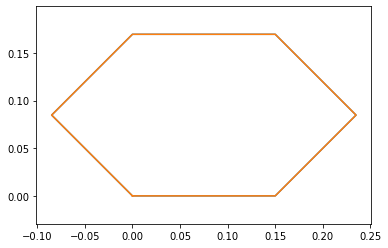

In [30]:
points = [pNbase,pbaseA,pAC,pCend,pendD,pDB,pNBtip]
points_output = PointsOutput(points, constant_values=system.constant_values)
points_output.calc(numpy.array([ini0,ini]),numpy.array([0,1]))
points_output.plot_time()

#### 5. Solution: Add the code from the bottom of the pendulum example for solving for f=ma, integrating, plotting, and animating. Run the code to see your results. It should look similar to the pendulum example with constraints added, as in like a rag-doll or floppy

In [31]:
f,ma = system.getdynamics()

2022-04-28 03:57:35,846 - pynamics.system - INFO - getting dynamic equations


In [32]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2022-04-28 03:57:43,891 - pynamics.system - INFO - solving a = f/m and creating function
2022-04-28 03:57:54,649 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-04-28 03:58:12,822 - pynamics.system - INFO - done solving a = f/m and creating function
2022-04-28 03:58:12,825 - pynamics.system - INFO - calculating function for lambdas


In [33]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-04-28 03:58:12,867 - pynamics.integration - INFO - beginning integration
2022-04-28 03:58:12,877 - pynamics.system - INFO - integration at time 0000.00
2022-04-28 03:58:13,571 - pynamics.integration - INFO - finished integration


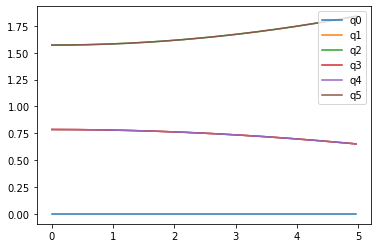

In [34]:
plt.figure()
artists = plt.plot(t,states[:,:6])
plt.legend(artists,['q0','q1','q2','q3','q4','q5'])

2022-04-28 03:58:15,031 - pynamics.output - INFO - calculating outputs
2022-04-28 03:58:15,198 - pynamics.output - INFO - done calculating outputs


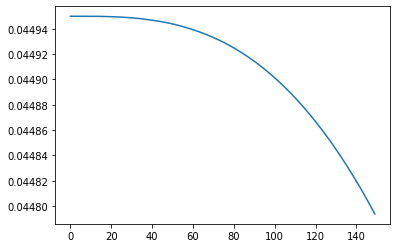

In [35]:
KE = system.get_KE()
PE = system.getPEGravity(pNbase) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

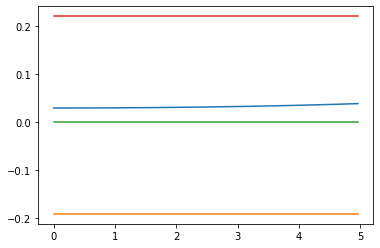

In [36]:
if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)

2022-04-28 03:58:20,948 - pynamics.output - INFO - calculating outputs
2022-04-28 03:58:21,071 - pynamics.output - INFO - done calculating outputs


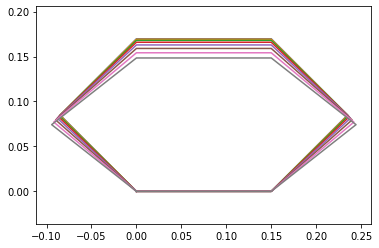

In [37]:
points = [pNbase,pbaseA,pAC,pCend,pendD,pDB,pNBtip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

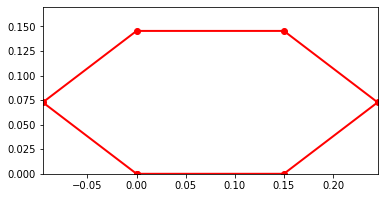

In [38]:
points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

In [39]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())